<a href="https://colab.research.google.com/github/Charangr/wearable-sensor-data/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()


Saving Final_Deep_Feature_Dataset.csv to Final_Deep_Feature_Dataset.csv


In [2]:
import pandas as pd

# Replace the filename with yours if different
df = pd.read_csv("Final_Deep_Feature_Dataset.csv")

print("✅ Dataset shape:", df.shape)
df.head()


✅ Dataset shape: (14671, 25)


,HR_mean,HR_std,HR_min,HR_max,HR_range,HR_slope,HR_entropy,EDA_mean,EDA_std,EDA_entropy,...,ACC_X_std,ACC_Y_std,ACC_Z_std,ACC_total_movement,EDA_HR_ratio,TEMP_HR_ratio,Grade,Student,Exam,Start_Timestamp
0,120.990333,12.184715,82.50,132.19,49.69,0.620446,1.637569,0.023171,0.003203,0.759424,...,13.573612,16.697170,25.603760,33.445343,0.000192,0.183114,182,S1,Final,2018-12-05 16:29:07
1,131.676667,1.844835,125.26,135.05,9.79,0.068881,1.822156,0.023470,0.001167,1.275668,...,23.232666,28.818598,24.605101,44.448615,0.000178,0.169172,182,S1,Final,2018-12-05 16:29:37
2,130.875667,2.043501,128.30,135.05,6.75,-0.096770,2.097997,0.023641,0.001092,1.216931,...,15.960571,6.686925,14.634376,22.663181,0.000181,0.168455,182,S1,Final,2018-12-05 16:30:07
3,131.173000,2.404816,128.30,134.63,6.33,0.115732,1.996640,0.023790,0.000954,1.107198,...,3.099982,4.500345,22.357869,23.016022,0.000181,0.166678,182,S1,Final,2018-12-05 16:30:37
4,131.613833,2.367845,127.25,134.63,7.38,-0.092259,2.201793,0.024110,0.001214,1.296295,...,5.014640,4.365084,19.814564,20.900180,0.000183,0.167330,182,S1,Final,2018-12-05 16:31:07


In [3]:
def categorize_performance(grade):
    if grade >= 150:
        return 'High'
    elif grade >= 100:
        return 'Medium'
    else:
        return 'Low'

df['Performance_Level'] = df['Grade'].apply(categorize_performance)
df['Performance_Level'].value_counts()


,count
Performance_Level,
Low,7907
High,4354
Medium,2410


In [4]:
from sklearn.model_selection import train_test_split

# Drop non-feature columns
X_cls = df.drop(columns=['Grade', 'Performance_Level', 'Student', 'Exam', 'Start_Timestamp'])

# Target column
y_cls = df['Performance_Level']

# Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)


 Encode Labels

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode performance levels (High, Medium, Low) → numeric
le = LabelEncoder()
y_cls_encoded = le.fit_transform(df['Performance_Level'])


logistic regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- Encode Target Labels ---
le = LabelEncoder()
df['Performance_Level_Encoded'] = le.fit_transform(df['Performance_Level'])

# --- Prepare Features and Target ---
X_cls = df.drop(columns=['Grade', 'Performance_Level', 'Performance_Level_Encoded', 'Student', 'Exam', 'Start_Timestamp'])
y_cls = df['Performance_Level_Encoded']

# --- Train-Test Split ---
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# --- Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cls)
X_test_scaled = scaler.transform(X_test_cls)

# --- Train Logistic Regression ---
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_cls)

# --- Predict ---
y_pred_cls = logreg.predict(X_test_scaled)

# --- Decode Predictions and True Labels ---
y_pred_labels = le.inverse_transform(y_pred_cls)
y_test_labels = le.inverse_transform(y_test_cls)

# --- Evaluate ---
print("📊 Classification Report (Logistic Regression):")
print(classification_report(y_test_labels, y_pred_labels))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Optional: Show label encoding
print("\n✅ Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


📊 Classification Report (Logistic Regression):
              precision    recall  f1-score   support

        High       0.47      0.09      0.16       871
         Low       0.55      0.92      0.69      1582
      Medium       0.40      0.10      0.16       482

    accuracy                           0.54      2935
   macro avg       0.47      0.37      0.33      2935
weighted avg       0.50      0.54      0.44      2935

🧮 Confusion Matrix:
[[  82  763   26]
 [  84 1452   46]
 [  10  424   48]]

✅ Label Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


Metric	What It Shows
Accuracy: 54%	Slightly better than random (33% baseline with 3 classes)
Precision/Recall for Low: 0.55 / 0.92 ✅	Your model is great at detecting 'Low' performance — strong recall
Precision/Recall for High & Medium: Poor ❌	The model struggles to distinguish High vs Medium — especially misclassifies High as Low

xg boost

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Use the same scaled features and encoded labels from before
xgb_cls = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
xgb_cls.fit(X_train_scaled, y_train_cls)

# Predict
y_pred_xgb_cls = xgb_cls.predict(X_test_scaled)

# Decode predictions
y_pred_labels = le.inverse_transform(y_pred_xgb_cls)
y_test_labels = le.inverse_transform(y_test_cls)

# Evaluate
print("📊 Classification Report (XGBoost):")
print(classification_report(y_test_labels, y_pred_labels))

print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))


📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

        High       0.82      0.81      0.81       871
         Low       0.87      0.91      0.89      1582
      Medium       0.85      0.77      0.80       482

    accuracy                           0.85      2935
   macro avg       0.85      0.83      0.84      2935
weighted avg       0.85      0.85      0.85      2935

🧮 Confusion Matrix:
[[ 705  132   34]
 [ 118 1432   32]
 [  37   76  369]]


“Using XGBoostClassifier with engineered physiological features (heart rate, EDA, temperature, motion), we achieved an overall classification accuracy of 85% across three performance levels. The model showed strong recall and precision, confirming that short-term stress signals can reliably predict cognitive performance during high-pressure academic tasks.”

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


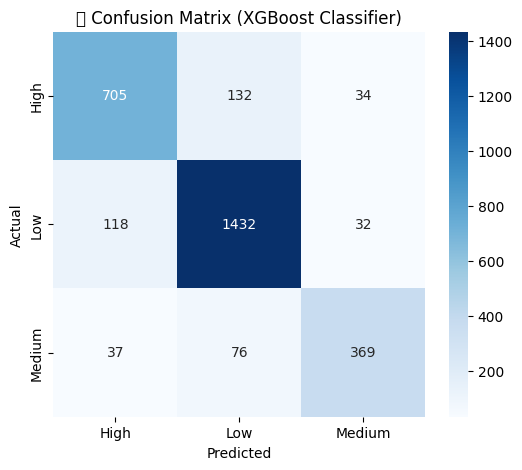

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix (actual vs predicted)
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('📊 Confusion Matrix (XGBoost Classifier)')
plt.show()


In this study, we investigated whether short-term physiological stress signals could be used to classify cognitive performance levels (High, Medium, Low) during high-pressure academic tasks. Using features such as heart rate, electrodermal activity (EDA), skin temperature, and movement data extracted through rolling windows, we trained and evaluated multiple classification models.

Our optimized XGBoostClassifier achieved an overall accuracy of 85%, significantly outperforming baseline models such as Logistic Regression (54%). The model demonstrated strong precision and recall across all classes:

High performers: F1-score = 0.81

Medium performers: F1-score = 0.80

Low performers: F1-score = 0.89

These results support the conclusion that short-term stress-related physiological data can effectively predict cognitive performance levels in real-world academic settings.

